In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay

OUTPUT = 1
DROP = True
IQR_OPTION = 1
USE_IQR = True

data = pd.read_csv("breast-cancer.csv")
diagnosis = data['diagnosis']
columns = list(data)
columns = columns[2:]

In [62]:
if OUTPUT:
    print(data.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [63]:
if OUTPUT:
    num_rows = len(data.index)
    num_cols = len(data.columns)

    print(f"Number of features: {num_cols}")
    print(f"Number of entries: {num_rows}")


Number of features: 32
Number of entries: 569


In [64]:
if OUTPUT:
    print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [65]:
if OUTPUT:
    print(data.describe())

                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813     

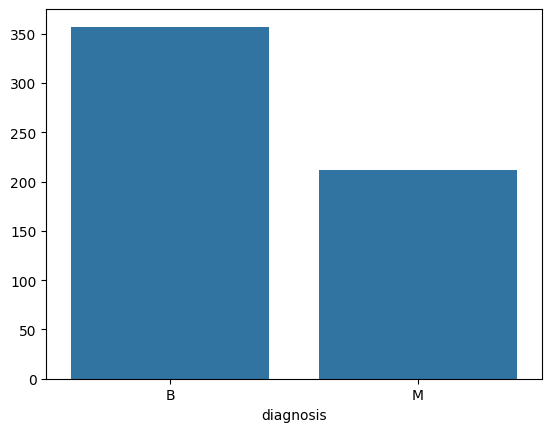

In [66]:
if OUTPUT:
    categories = ['M', 'L']
    plt.figure()
    class_count = diagnosis.value_counts()
    sns.barplot(x=class_count.index, y=class_count.values)

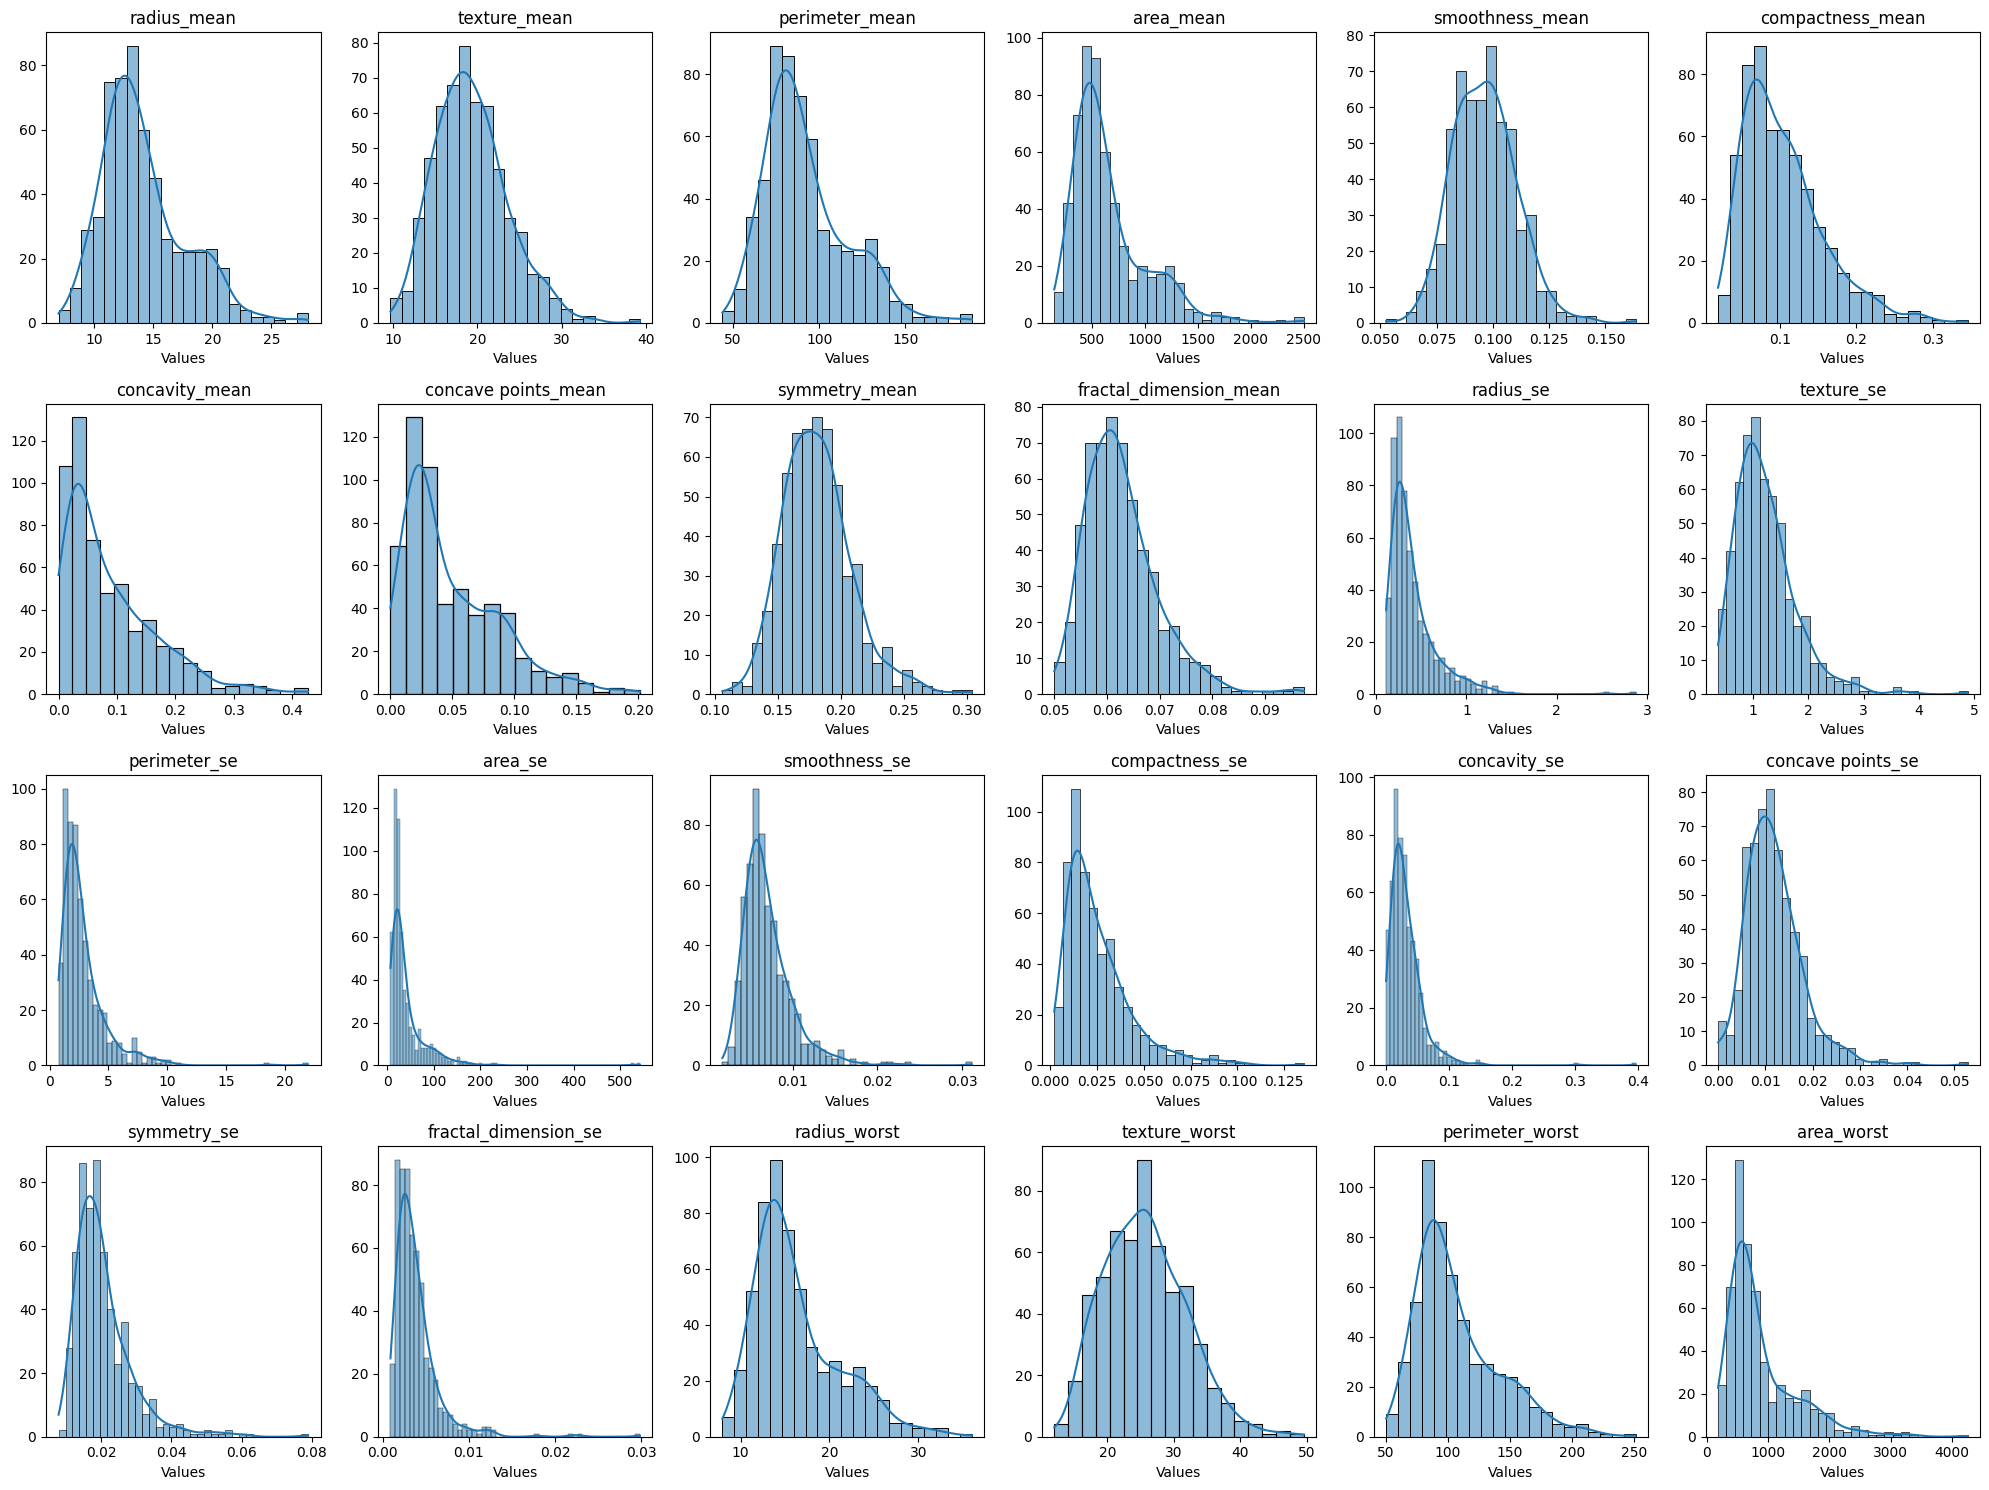

In [67]:
fig, axes = plt.subplots(4, 6, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes[:data.shape[1]]):
    sns.histplot(data.iloc[:, i + 2], kde=True, ax=ax)
    ax.set_title(f"{columns[i]}")
    ax.set_xlabel("Values")
    ax.set_ylabel("")

for ax in axes[data.shape[1]:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


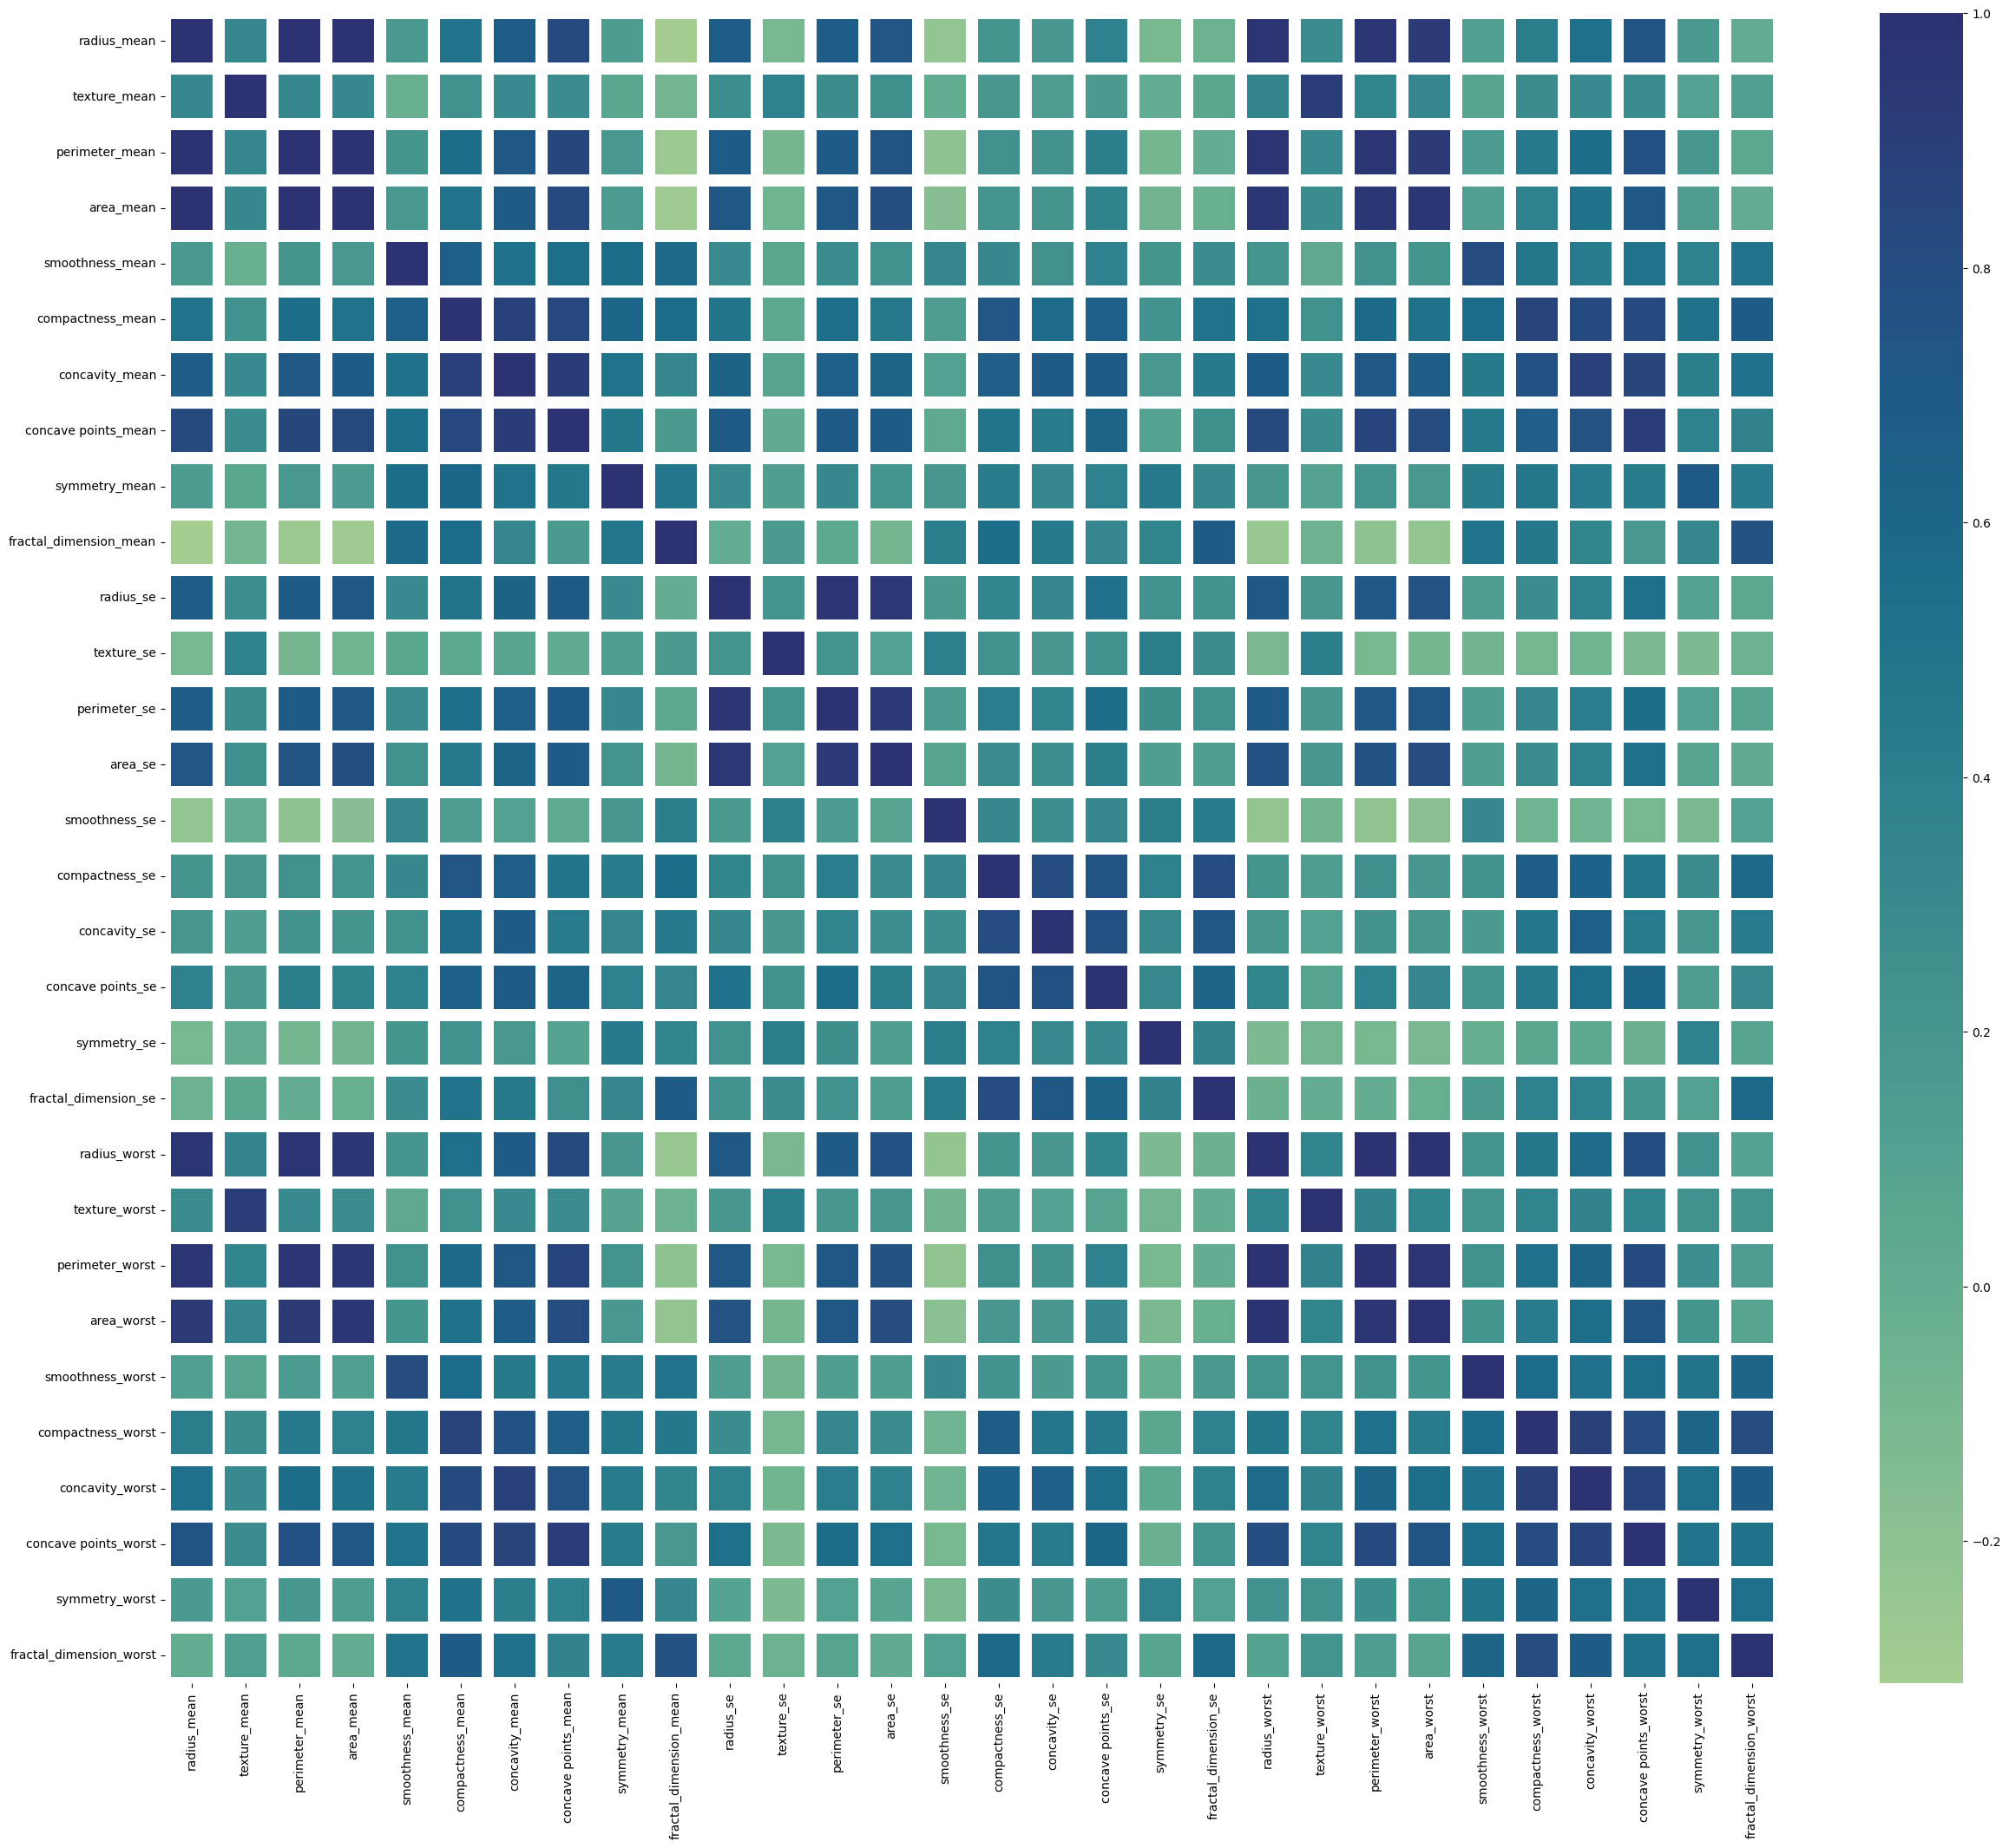

In [68]:
if OUTPUT:
    plt.figure(figsize=(30,25))
    sns.heatmap(data=(data.iloc[:, 2:]).corr(), linewidths=10, cmap='crest')

# Data Preprocessing

### Remove ID column

In [69]:
data = data.iloc[:, 1:]

### Check if there are any empty values

In [70]:
if OUTPUT:
    print(data.isnull().any())

diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_worst             False
fractal_di

### Outlier Detection and Treatment

#### Using IQR

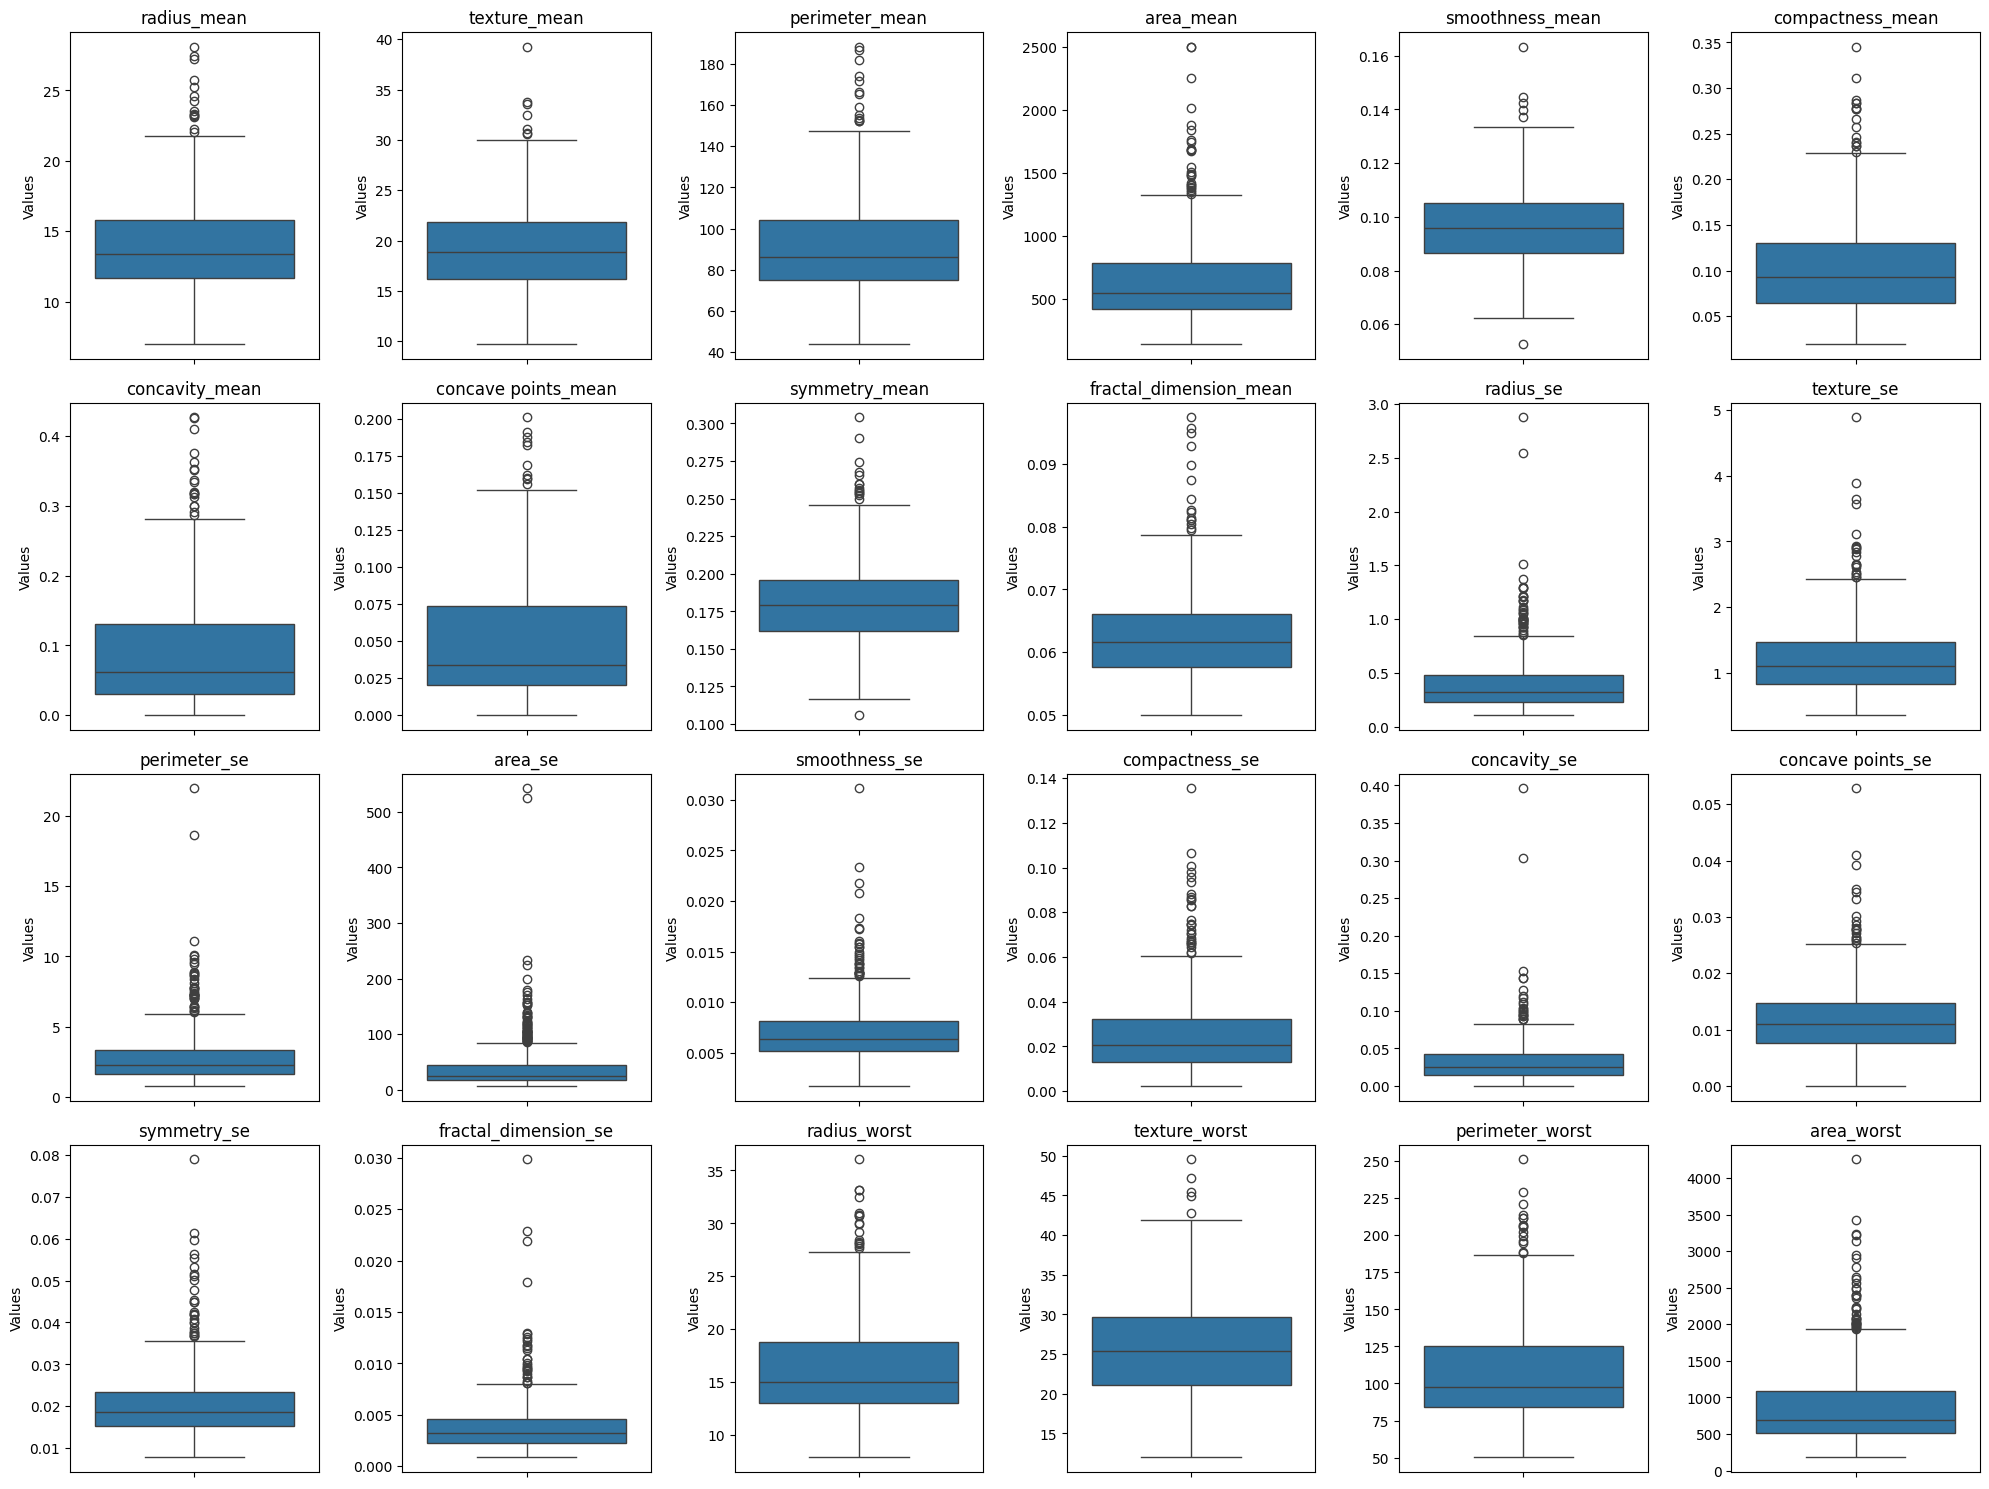

In [71]:
features = data.iloc[:, 1:]

fig, axes = plt.subplots(4, 6, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes[:data.shape[1]]):
    sns.boxplot(y=data.iloc[:, i + 1], ax=ax)
    ax.set_title(f"{columns[i]}")
    ax.set_xlabel("")
    ax.set_ylabel("Values")

for ax in axes[data.shape[1]:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

##### IQR Option 1: Detect Outliers Based on All Values

For radius_mean there are 14 outliers
For texture_mean there are 7 outliers
For perimeter_mean there are 13 outliers
For area_mean there are 25 outliers
For smoothness_mean there are 6 outliers
For compactness_mean there are 16 outliers
For concavity_mean there are 18 outliers
For concave points_mean there are 10 outliers
For symmetry_mean there are 15 outliers
For fractal_dimension_mean there are 15 outliers
For radius_se there are 38 outliers
For texture_se there are 20 outliers
For perimeter_se there are 38 outliers
For area_se there are 65 outliers
For smoothness_se there are 30 outliers
For compactness_se there are 28 outliers
For concavity_se there are 22 outliers
For concave points_se there are 19 outliers
For symmetry_se there are 27 outliers
For fractal_dimension_se there are 28 outliers
For radius_worst there are 17 outliers
For texture_worst there are 5 outliers
For perimeter_worst there are 15 outliers
For area_worst there are 35 outliers
For smoothness_worst there are 7 ou

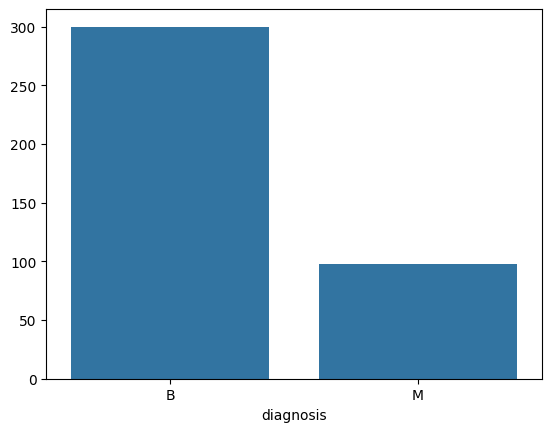

In [72]:
if USE_IQR:
    if IQR_OPTION == 1:
        index = []

        for feature in features:
            values = data[feature].values
            q1 = np.percentile(values, 25)
            q2 = np.percentile(values, 50)
            q3 = np.percentile(values, 75)
            iqr = q3 - q1

            max = q3 + (1.5 * iqr)
            min = q1 - (1.5 * iqr)
            count = 0
            for i in range(len(values)):
                if values[i] > max or values[i] < min:
                    count += 1
                    index.append(i)
                    if not DROP:
                        if values[i] > max:
                            values[i] = max
                        else:
                            values[i] = min
            if OUTPUT:
                print(f"For {feature} there are {count} outliers")
            data[feature] = values

        if DROP:
            index = list(dict.fromkeys(index))
            if OUTPUT:
                print(f"Number of entries in old dataframe: {len(data)}")
            no_outliers_data = data.drop(index=index)
            if OUTPUT:
                print(f"Number of entries in new dataframe: {len(no_outliers_data)}")
            data = no_outliers_data.reset_index(drop=True)
            if OUTPUT:
                categories = ['M', 'L']
                plt.figure()
                class_count = no_outliers_data['diagnosis'].value_counts()
                print(class_count)
                sns.barplot(x=class_count.index, y=class_count.values)

##### IQR Option 2: Detect Outliers Based on Diagnosis

In [73]:
if USE_IQR:
    if IQR_OPTION == 2:
        benign = data[data['diagnosis'] == 'B'].reset_index(drop=True)

        index = []
        features = list(benign)
        features = features[1:]
        for feature in features:
            values = benign[feature].values

            q1 = np.percentile(values, 25)
            q2 = np.percentile(values, 50)
            q3 = np.percentile(values, 75)
            iqr = q3 - q1

            max = q3 + (1.5 * iqr)
            min = q1 - (1.5 * iqr)
            count = 0
            for i in range(len(values)):
                if values[i] > max or values[i] < min:
                    count += 1
                    index.append(i)
                    if not DROP:
                        if values[i] > max:
                            values[i] = max
                        else:
                            values[i] = min
            benign[feature] = values


        if DROP:
            if OUTPUT:
                print(f"Number of benign cases before outlier removal {len(benign)}")
            index = list(dict.fromkeys(index))
            no_outliers_benign = benign.drop(index=index)
            if OUTPUT:
                print(f"Number of benign cases after outlier removal {len(no_outliers_benign)}")

In [74]:
if USE_IQR:
    if IQR_OPTION == 2:
        malignant = data[data['diagnosis'] == 'M'].reset_index(drop=True)


        index = []
        features = list(malignant)
        features = features[1:]
        for feature in features:
            values = malignant[feature].values

            q1 = np.percentile(values, 25)
            q2 = np.percentile(values, 50)
            q3 = np.percentile(values, 75)
            iqr = q3 - q1

            max = q3 + (1.5 * iqr)
            min = q1 - (1.5 * iqr)
            count = 0
            for i in range(len(values)):
                if values[i] > max or values[i] < min:
                    count += 1
                    index.append(i)
                    if not DROP:
                        if values[i] > max:
                            values[i] = max
                        else:
                            values[i] = min
            malignant[feature] = values

        if DROP:
            if OUTPUT:
                print(f"Number of malignant cases before outlier removal {len(benign)}")
            index = list(dict.fromkeys(index))
            no_outliers_malignant = malignant.drop(index=index)
            if OUTPUT:
                print(f"Number of malignant cases after outlier removal {len(no_outliers_malignant)}")

In [75]:
if USE_IQR:
    if IQR_OPTION == 2:
        if DROP:
            malignant = no_outliers_malignant
            benign = no_outliers_benign
            temp_df = pd.concat([malignant, benign], ignore_index=True)
            if OUTPUT:
                plt.figure()
                class_count = temp_df['diagnosis'].value_counts()
                print(class_count)
                sns.barplot(x=class_count.index, y=class_count.values)


        new_data = pd.concat([malignant, benign], ignore_index=True)
        data = new_data.sample(frac=1).reset_index(drop=True)





### Label Encoding

In [76]:
labelEncoder = LabelEncoder()
labelEncoder.fit(data['diagnosis'])
data['diagnosis'] = labelEncoder.transform(data['diagnosis'])
if OUTPUT:
    print(data['diagnosis'])

0      1
1      1
2      1
3      1
4      1
      ..
393    0
394    0
395    0
396    0
397    1
Name: diagnosis, Length: 398, dtype: int64


In [77]:
data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368
1,1,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510
2,1,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,...,19.19,33.88,123.80,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
3,1,15.78,17.89,103.60,781.0,0.09710,0.12920,0.09954,0.06606,0.1842,...,20.42,27.28,136.50,1299.0,0.1396,0.5609,0.3965,0.18100,0.3792,0.10480
4,1,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,...,16.84,27.66,112.00,876.5,0.1131,0.1924,0.2322,0.11190,0.2809,0.06287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0,12.88,28.92,82.50,514.3,0.08123,0.05824,0.06195,0.02343,0.1566,...,13.89,35.74,88.84,595.7,0.1227,0.1620,0.2439,0.06493,0.2372,0.07242
394,0,10.29,27.61,65.67,321.4,0.09030,0.07658,0.05999,0.02738,0.1593,...,10.84,34.91,69.57,357.6,0.1384,0.1710,0.2000,0.09127,0.2226,0.08283
395,0,14.59,22.68,96.39,657.1,0.08473,0.13300,0.10290,0.03736,0.1454,...,15.48,27.27,105.90,733.5,0.1026,0.3171,0.3662,0.11050,0.2258,0.08004
396,0,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,...,15.30,33.17,100.20,706.7,0.1241,0.2264,0.1326,0.10480,0.2250,0.08321


### Data Normalization




In [78]:
normalizer = MinMaxScaler(feature_range=(1, 10))
normalized = normalizer.fit_transform(data)
data = pd.DataFrame(normalized, columns=data.columns)
if OUTPUT:
    print(data)

     diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         10.0     8.452495      5.598507        8.257632   7.858054   
1         10.0     5.450070      5.979104        5.443038   4.323077   
2         10.0     6.977735      7.058209        6.639719   6.005270   
3         10.0     6.819017      4.662687        6.725880   5.876753   
4         10.0     6.865310      7.376119        6.735454   5.889758   
..         ...          ...           ...             ...        ...   
393        1.0     4.901168      9.601493        4.705882   3.836549   
394        1.0     3.188331      9.014925        3.094671   2.360901   
395        1.0     6.032038      6.807463        6.035635   4.928942   
396        1.0     5.674921      8.808955        5.556005   4.495198   
397       10.0     7.361305      9.225373        7.175832   6.466553   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0           5.574774          5.411881        4.985462  

##Classification

#### Feature and Label splitting

In [79]:
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

#### Function to plot confusion matrix

In [80]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### 1. Decision Tree

In [81]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_model.fit(X_train1, y_train1)

y_pred1 = dt_model.predict(X_test1)

report1 = classification_report(y_test1, y_pred1)
print("Classification Report:\n", report1)
accuracy1 = accuracy_score(y_test1, y_pred1)
print(f"Accuracy: {accuracy1:.2f}")

Classification Report:
               precision    recall  f1-score   support

         1.0       0.91      0.96      0.94        55
        10.0       0.91      0.80      0.85        25

    accuracy                           0.91        80
   macro avg       0.91      0.88      0.89        80
weighted avg       0.91      0.91      0.91        80

Accuracy: 0.91


#### Decision Tree Plot

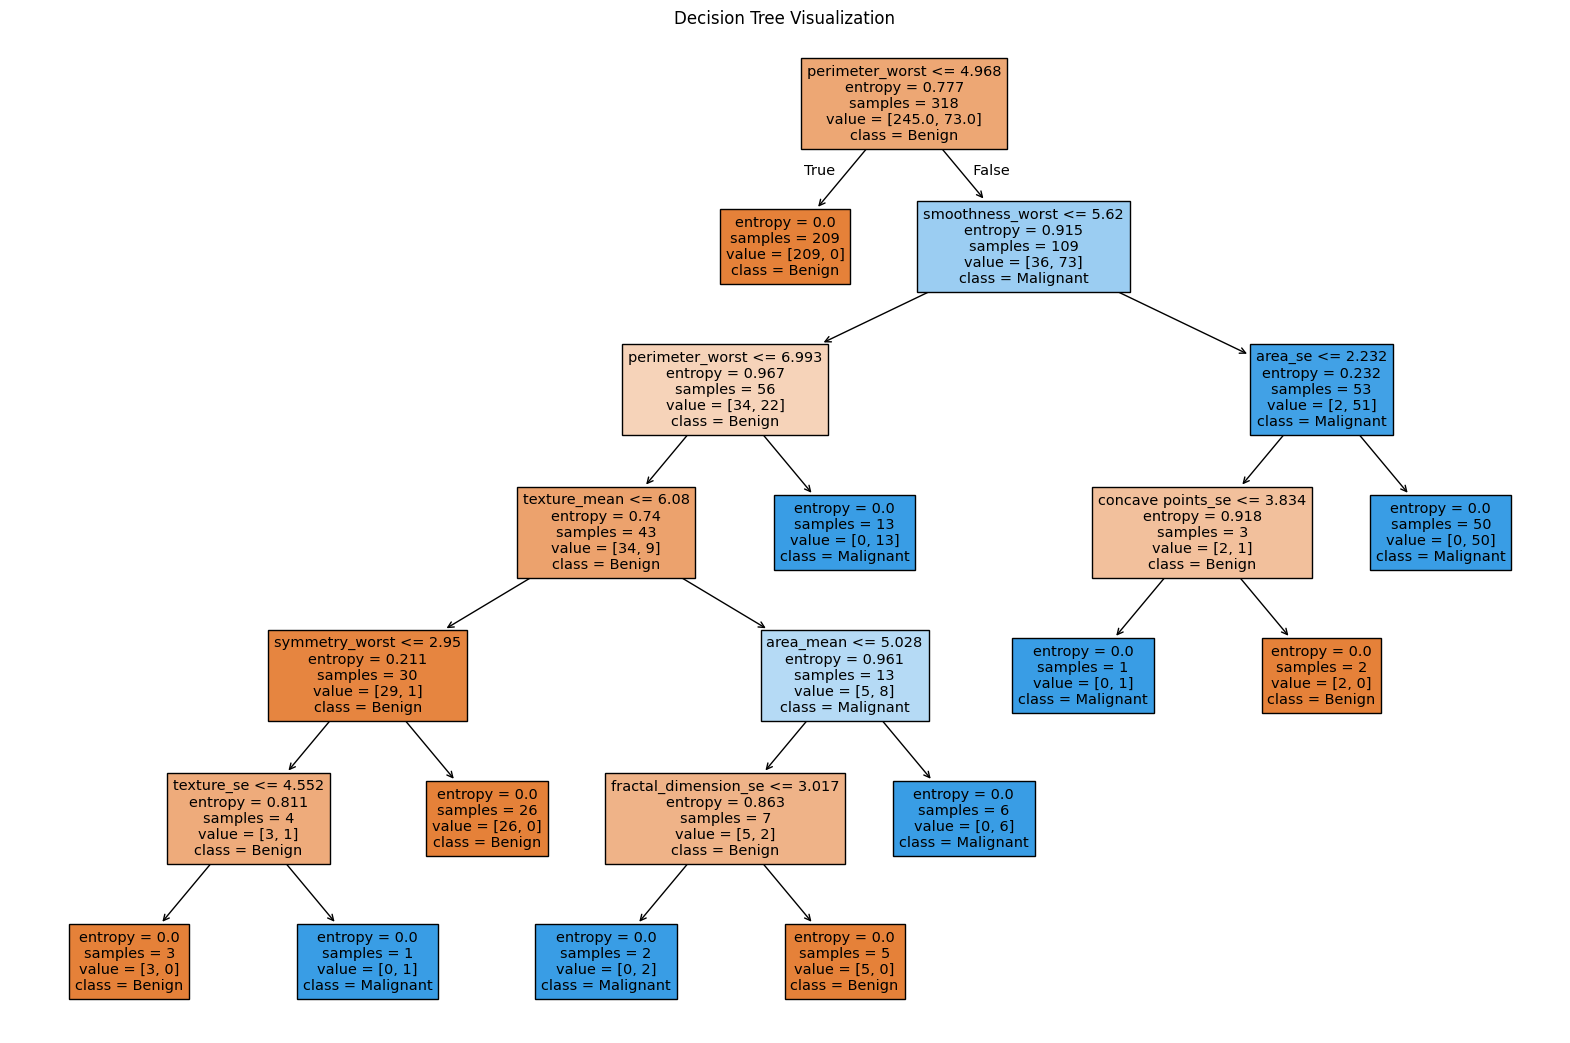

In [82]:
plt.figure(figsize=(20, 13))
plot_tree(dt_model, feature_names=X.columns, class_names=['Benign', 'Malignant'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

#### Decision Tree Confusion

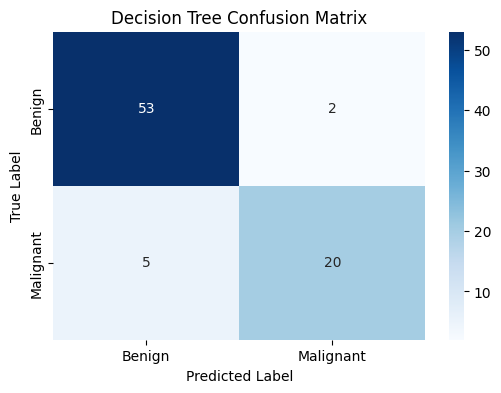

In [83]:
plot_confusion_matrix(y_test1, y_pred1, "Decision Tree Confusion Matrix")

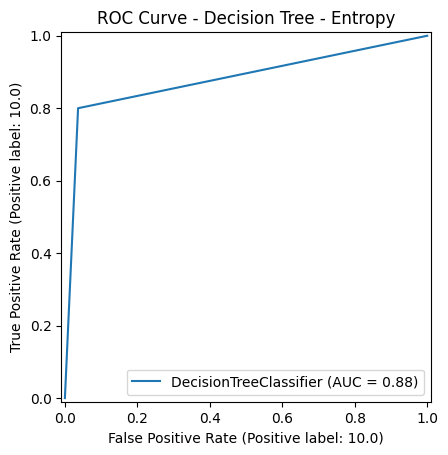

In [84]:
RocCurveDisplay.from_estimator(dt_model, X_test1, y_test1)
plt.title("ROC Curve - Decision Tree - Entropy")
plt.show()

#### Using Gini impurity instead of Entropy/information gain

In [85]:
dt_model_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_model_gini.fit(X_train1, y_train1)

y_pred1_gini = dt_model_gini.predict(X_test1)

report1_gini = classification_report(y_test1, y_pred1_gini)
print("Classification Report when Gini impurity index used:\n", report1_gini)
accuracy1_gini = accuracy_score(y_test1, y_pred1_gini)
print(f"Accuracy when Gini impurity index used: {accuracy1_gini:.2f}")

Classification Report when Gini impurity index used:
               precision    recall  f1-score   support

         1.0       0.93      0.98      0.96        55
        10.0       0.95      0.84      0.89        25

    accuracy                           0.94        80
   macro avg       0.94      0.91      0.92        80
weighted avg       0.94      0.94      0.94        80

Accuracy when Gini impurity index used: 0.94


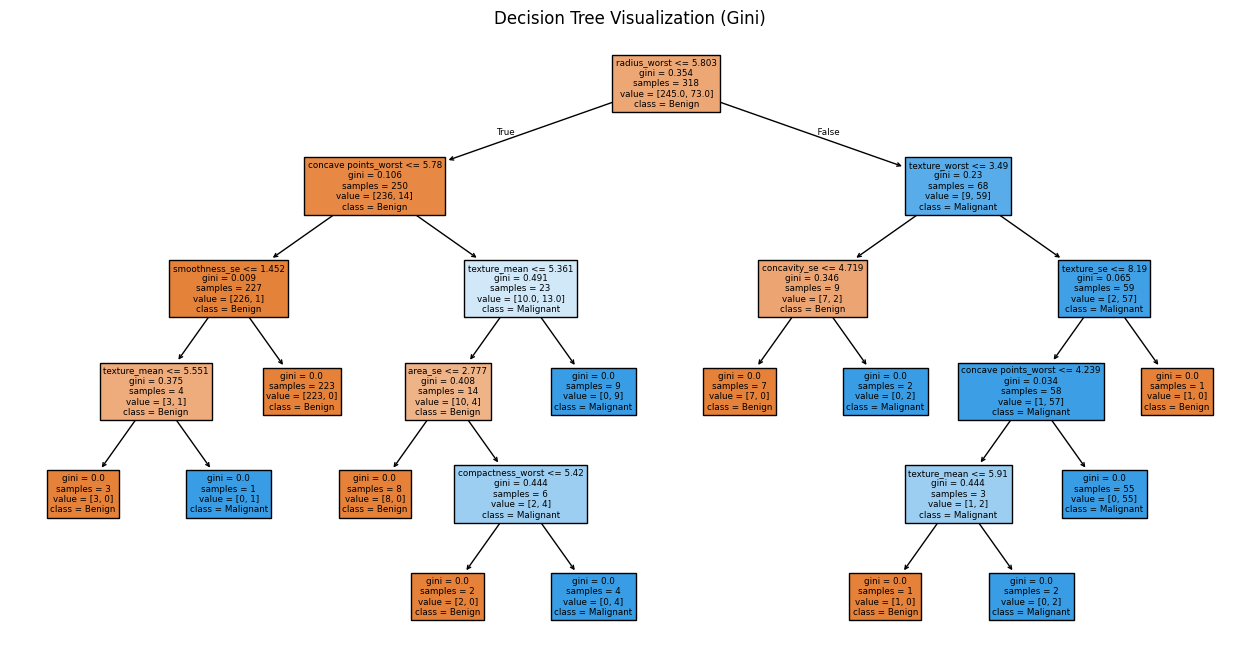

In [86]:
plt.figure(figsize=(16, 8))
plot_tree(dt_model_gini, feature_names=X.columns, class_names=['Benign', 'Malignant'], filled=True)
plt.title("Decision Tree Visualization (Gini)")
plt.show()

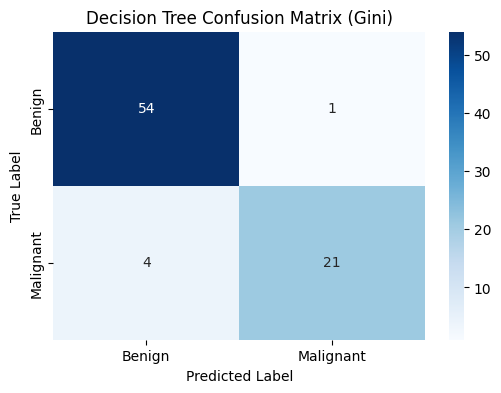

In [87]:
plot_confusion_matrix(y_test1, y_pred1_gini, "Decision Tree Confusion Matrix (Gini)")

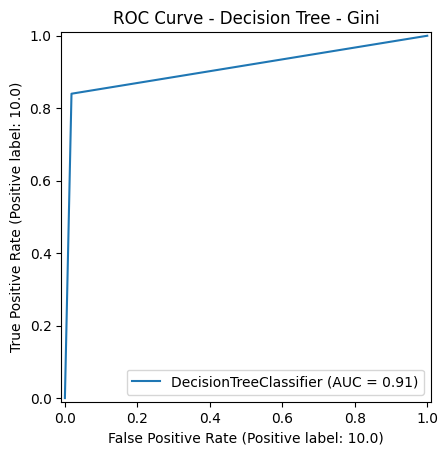

In [88]:
RocCurveDisplay.from_estimator(dt_model_gini, X_test1, y_test1)
plt.title("ROC Curve - Decision Tree - Gini")
plt.show()

### 2. K Nearest Neighbor

In [89]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train2, y_train2)

y_pred2 = knn_model.predict(X_test2)

report2 = classification_report(y_test2, y_pred2)
print("Classification Report:\n", report2)
accuracy2 = accuracy_score(y_test2, y_pred2)
print(f"Accuracy: {accuracy2:.2f}")

Classification Report:
               precision    recall  f1-score   support

         1.0       0.93      1.00      0.96        55
        10.0       1.00      0.84      0.91        25

    accuracy                           0.95        80
   macro avg       0.97      0.92      0.94        80
weighted avg       0.95      0.95      0.95        80

Accuracy: 0.95


#### Trying Different values for K

In [90]:
for k in range(1, 11):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train2, y_train2)
    y_pred2 = knn_model.predict(X_test2)
    print(f"k = {k}, Accuracy: {accuracy_score(y_test2, y_pred2):.2f}")

k = 1, Accuracy: 0.96
k = 2, Accuracy: 0.94
k = 3, Accuracy: 0.96
k = 4, Accuracy: 0.95
k = 5, Accuracy: 0.95
k = 6, Accuracy: 0.95
k = 7, Accuracy: 0.94
k = 8, Accuracy: 0.93
k = 9, Accuracy: 0.93
k = 10, Accuracy: 0.94


In [91]:
knn_model_1 = KNeighborsClassifier(n_neighbors=1)
knn_model_1.fit(X_train2, y_train2)
knn_model_3 = KNeighborsClassifier(n_neighbors=3)
knn_model_3.fit(X_train2, y_train2)


y_pred2_1 = knn_model_1.predict(X_test2)

report2_1 = classification_report(y_test2, y_pred2_1)
print("Classification Report when K=1:\n", report2_1)
accuracy2_1 = accuracy_score(y_test2, y_pred2_1)
print(f"Accuracy when K=1: {accuracy2_1:.2f} \n")

y_pred2_3 = knn_model_3.predict(X_test2)

report2_3 = classification_report(y_test2, y_pred2_1)
print("Classification Report when K=3:\n", report2_3)
accuracy2_3 = accuracy_score(y_test2, y_pred2_3)
print(f"Accuracy when K=3: {accuracy2_3:.2f}")

Classification Report when K=1:
               precision    recall  f1-score   support

         1.0       0.96      0.98      0.97        55
        10.0       0.96      0.92      0.94        25

    accuracy                           0.96        80
   macro avg       0.96      0.95      0.96        80
weighted avg       0.96      0.96      0.96        80

Accuracy when K=1: 0.96 

Classification Report when K=3:
               precision    recall  f1-score   support

         1.0       0.96      0.98      0.97        55
        10.0       0.96      0.92      0.94        25

    accuracy                           0.96        80
   macro avg       0.96      0.95      0.96        80
weighted avg       0.96      0.96      0.96        80

Accuracy when K=3: 0.96


#### KNN Confusion Matrix

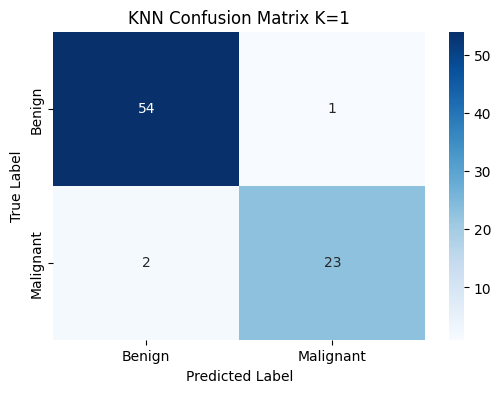

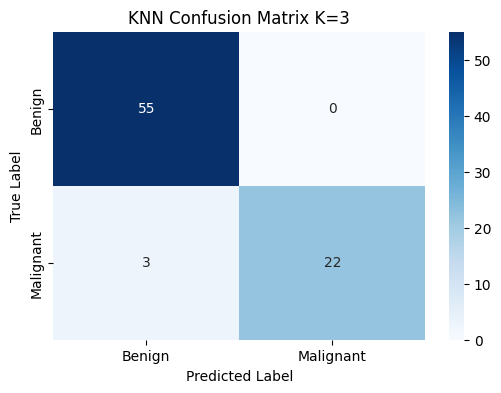

In [92]:
plot_confusion_matrix(y_test2, y_pred2_1, "KNN Confusion Matrix K=1")
plot_confusion_matrix(y_test2, y_pred2_3, "KNN Confusion Matrix K=3")

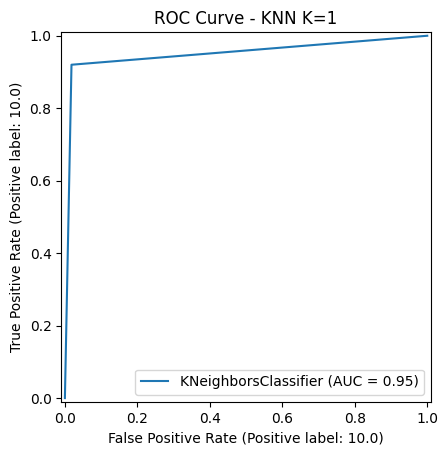

In [93]:
RocCurveDisplay.from_estimator(knn_model_1, X_test2, y_test2)
plt.title("ROC Curve - KNN K=1")
plt.show()

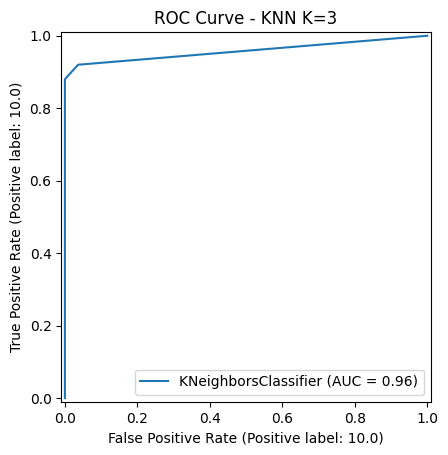

In [94]:
RocCurveDisplay.from_estimator(knn_model_3, X_test2, y_test2)
plt.title("ROC Curve - KNN K=3")
plt.show()

### 3. Naive Bayes

In [95]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state=42)

nb_model = GaussianNB()
nb_model.fit(X_train3, y_train3)

y_pred3 = nb_model.predict(X_test3)

report3 = classification_report(y_test3, y_pred3)
print("Classification Report:\n", report3)
accuracy3 = accuracy_score(y_test3, y_pred3)
print(f"Accuracy: {accuracy3:.2f}")

Classification Report:
               precision    recall  f1-score   support

         1.0       0.94      0.93      0.94        55
        10.0       0.85      0.88      0.86        25

    accuracy                           0.91        80
   macro avg       0.90      0.90      0.90        80
weighted avg       0.91      0.91      0.91        80

Accuracy: 0.91


#### Naive Bayes Confusion Matrix

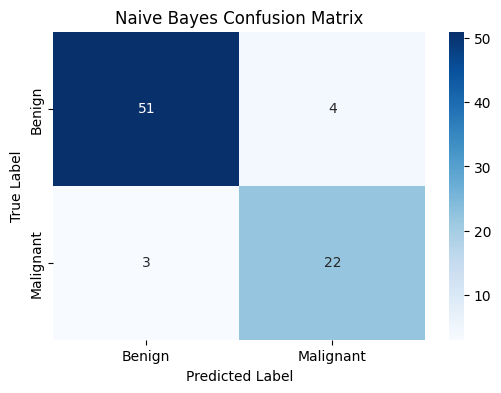

In [96]:
plot_confusion_matrix(y_test3, y_pred3, "Naive Bayes Confusion Matrix")

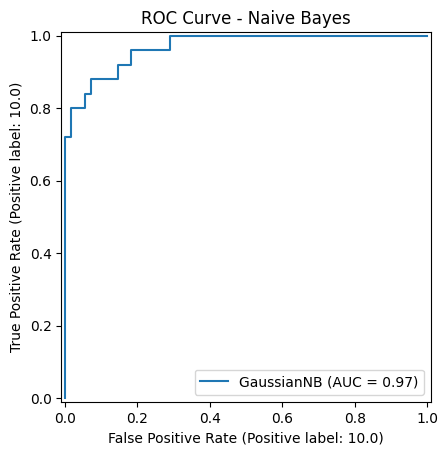

In [97]:
RocCurveDisplay.from_estimator(nb_model, X_test3, y_test3)
plt.title("ROC Curve - Naive Bayes")
plt.show()

In [98]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train4, y_train4)

# Make predictions
y_pred4 = rf_model.predict(X_test4)

# Evaluate the model
report4 = classification_report(y_test4, y_pred4)
accuracy4 = accuracy_score(y_test4, y_pred4)

# Print the results
print("Classification Report:\n", report4)
print(f"Accuracy: {accuracy4:.2f}")

Classification Report:
               precision    recall  f1-score   support

         1.0       0.92      0.98      0.95        55
        10.0       0.95      0.80      0.87        25

    accuracy                           0.93        80
   macro avg       0.93      0.89      0.91        80
weighted avg       0.93      0.93      0.92        80

Accuracy: 0.93


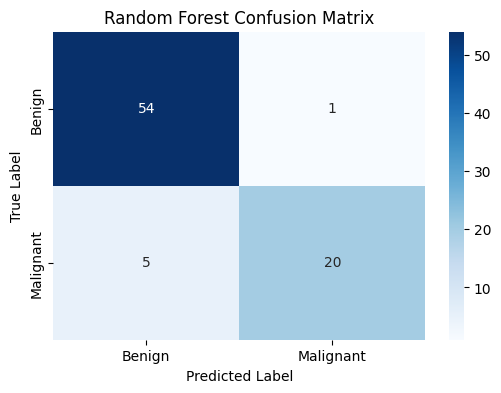

In [99]:
plot_confusion_matrix(y_test4, y_pred4, "Random Forest Confusion Matrix")

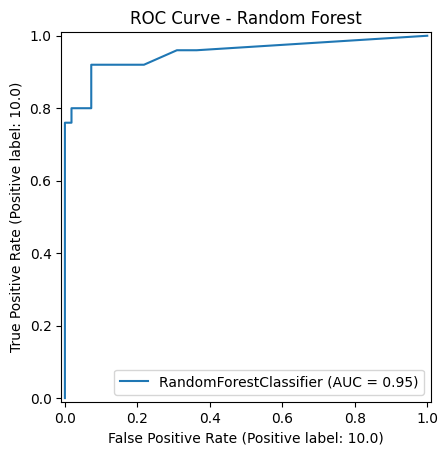

In [100]:
RocCurveDisplay.from_estimator(rf_model, X_test4, y_test4)
plt.title("ROC Curve - Random Forest")
plt.show()